<h1> Model 3: SVM </h1>

<h2> Import packages/classes and load data </h2>

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve, validation_curve, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Import change_summary
changelog = pd.read_csv('../Changelogs/change_summary.csv').to_dict(orient='records')

# Change summary intialization and check
change_summary = pd.DataFrame(changelog)
pd.set_option('display.max_colwidth', None)
display(change_summary)  

,column,change,rationale
0,age,Removed 3 row(s) where age > 125,Oldest verified human lived to be 122; values above 125 are likely errors or outliers.
1,loan_status,Dropped loan_status column,Target variable for classification; not needed in cleaned dataset.
2,person_income,"Capped person_income at $3,000,000 and applied log1p transformation",Handled extreme right skew and outliers in income distribution; log1p applied to normalize values and removed person_income for modeling.
3,loan_amnt,Applied log1p transformation to loan_amount,Handled extreme right skew and outliers in loan amount distribution; log1p applied to normalize values.
4,person_emp_exp,Removed 5 row(s) where person_emp_exp > 70,Unrealistic employment experience; values above 70 years are likely errors or outliers.
5,person_education,Combined Master and Doctorate categories into one group -- Graduate,Doctorate had the lowest frequency out of all the categories which could impact analysis
6,person_home_ownership,Combined RENT and OTHER into Non-Homeowner category and MORTGAGE and OWN into Homeowner category,RENT and MORTGAGE had high frequencies while OWN and OTHER had low frequencies which could impact analysis
7,"['person_gender', 'loan_intent', 'previous_loan_defaults_on_file', 'person_education_new', 'person_home_ownership_new']",Applied one-hot encoding (drop_first=True),Converted categorical variables into binary indicators for model compatibility.
8,loan_status,Readded loan_status column,Target variable for classification; readded after cleaning and preprocessing.


In [4]:
# Load cleaned data from CSV
df = pd.read_csv("../Data/cleaned_loan_data.csv")
df.head()

,person_age,person_emp_exp,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,log_income,log_loan_amt,person_gender_male,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_Yes,person_education_new_Bachelor,person_education_new_Graduate,person_education_new_High School,person_home_ownership_new_Non-Homeowner,loan_status
0,22,0,16.02,0.49,3,561,11.183713,10.463132,0,0,0,0,1,0,0,0,1,0,1,1
1,21,0,11.14,0.08,2,504,9.415971,6.908755,0,1,0,0,0,0,1,0,0,1,0,0
2,25,3,12.87,0.44,3,635,9.428592,8.612685,0,0,0,1,0,0,0,0,0,1,0,1
3,23,0,15.23,0.44,2,675,11.286702,10.463132,0,0,0,1,0,0,0,1,0,0,1,1
4,24,1,14.27,0.53,4,586,11.099469,10.463132,1,0,0,1,0,0,0,0,1,0,1,1


<h2> Data Prep </h2>

In [5]:
# Split the data into features and target variable
X = df.drop(columns=['loan_status'])
y = df['loan_status']

In [6]:
# Create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

X_train: (31494, 19)
X_test: (13498, 19)


In [7]:
# Scale the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Check for class imbalance
print(f"Class distribution in training set:\n{y_train.value_counts(normalize=True)}")
print(f"Class distribution in test set:\n{y_test.value_counts(normalize=True)}")

# Changelog addition
changelog.append({
    'column': 'numerical_columns',
    'change': 'Applied MinMaxScaler to training data; transformed test data using same scaler.',
    'rationale': 'Avoided data leakage by fitting scaler only on training data. Ensures proper model generalization and adheres to machine learning best practices.'
})


Class distribution in training set:
loan_status
0    0.777799
1    0.222201
Name: proportion, dtype: float64
Class distribution in test set:
loan_status
0    0.777819
1    0.222181
Name: proportion, dtype: float64


<h3> Apply Smote to the data and re-run the model</h3>

In [8]:
# SMOTE for handling class imbalance

#Initialize the smote classifier
smote = SMOTE(random_state=42)
X_smote_train, y_smote_train = smote.fit_resample(X_train_scaled, y_train)

# Check the class distribution after SMOTE
X_smote_test = X_test_scaled
y_smote_test = y_test

# Changelog entry for SMOTE
changelog.append({
    'column': 'subscribe_to_term_deposit',
    'change': f'Resampled training set with SMOTE (train shape now: {X_smote_train.shape}, test shape: {X_test.shape})',
    'rationale': 'Used SMOTE to correct class imbalance in training data for better model performance.'
})


<h2> Build the model </h2>


<h3> Base Model </h3>

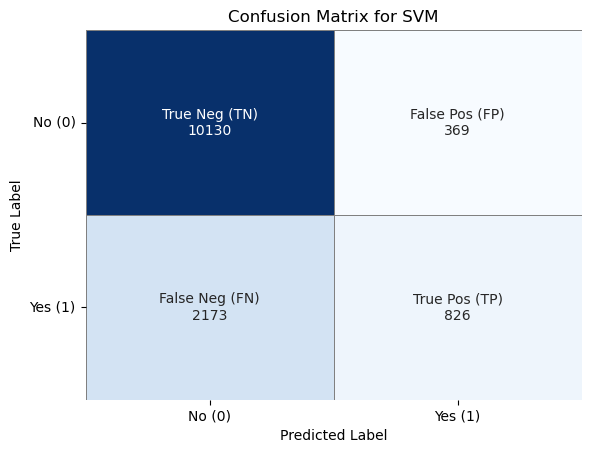

Accuracy Score:  0.8116758038227886
Precision Score:  0.6912133891213389
Recall Score:  0.27542514171390464
F1 Score:  0.3938960419647115
Specificity Score:  0.964853795599581


In [9]:
# --- Original SVM Model ---
svmBase = SVC(kernel='rbf', C=10, random_state=42)
svmBase.fit(X_train_scaled, y_train)
y_pred_svm = svmBase.predict(X_test_scaled)

cm_svm = confusion_matrix(y_test, y_pred_svm)

# Define labels for annotations
group_names = ['True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)']
group_counts = [f'{value}' for value in cm_svm.flatten()]
labels = [f'{name}\n{count}' for name, count in zip(group_names, group_counts)]
labels = np.array(labels).reshape(2, 2)


sns.heatmap(cm_svm, annot=labels, fmt='', cmap='Blues', cbar=False, linewidths=0.5, linecolor='gray')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for SVM')
plt.xticks(ticks=[0.5, 1.5], labels=['No (0)', 'Yes (1)'])
plt.yticks(ticks=[0.5, 1.5], labels=['No (0)', 'Yes (1)'], rotation=0)
plt.show()

#Evaluate the model
# --- Model Evaluation Scores ---
print('Accuracy Score: ', accuracy_score(y_test, y_pred_svm))
print('Precision Score: ', precision_score(y_test, y_pred_svm))
print('Recall Score: ', recall_score(y_test, y_pred_svm))
print('F1 Score: ', f1_score(y_test, y_pred_svm))

tn = cm_svm[0,0]
fp = cm_svm[0,1]
specificity = tn/(tn+fp)
print('Specificity Score: ', specificity)

<h3> Apply Smote to the data and re-run the model </h3>

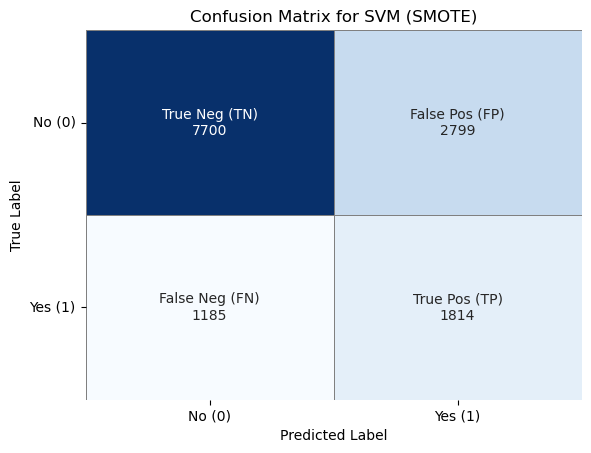

Accuracy Score:  0.7048451622462587
Precision Score:  0.39323650552785605
Recall Score:  0.60486828942981
F1 Score:  0.4766158696794535
Specificity Score:  0.7334031812553576


In [10]:
# --- Model with Smote Applied --- 

# Train SVM on SMOTE data
svm_smote = SVC(kernel='rbf', C=10, random_state=42)
svm_smote.fit(X_smote_train, y_smote_train)

# Predict
y_smote_pred_svm = svm_smote.predict(X_smote_test)

# Confusion matrix
cm_svm_smote = confusion_matrix(y_smote_test, y_smote_pred_svm)

# Define labels for annotations
group_names = ['True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)']
group_counts = [f'{value}' for value in cm_svm_smote.flatten()]
labels = [f'{name}\n{count}' for name, count in zip(group_names, group_counts)]
labels = np.array(labels).reshape(2, 2)


sns.heatmap(cm_svm_smote, annot=labels, fmt='', cmap='Blues', cbar=False, linewidths=0.5, linecolor='gray')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for SVM (SMOTE)')
plt.xticks(ticks=[0.5, 1.5], labels=['No (0)', 'Yes (1)'])
plt.yticks(ticks=[0.5, 1.5], labels=['No (0)', 'Yes (1)'], rotation=0)
plt.show()

#Evaluate the model
# --- Model Evaluation Scores ---
print('Accuracy Score: ', accuracy_score(y_test, y_smote_pred_svm))
print('Precision Score: ', precision_score(y_test, y_smote_pred_svm))
print('Recall Score: ', recall_score(y_test, y_smote_pred_svm))
print('F1 Score: ', f1_score(y_test, y_smote_pred_svm))

tn_smote = cm_svm_smote[0,0]
fp_smote = cm_svm_smote[0,1]
specificity_smote = tn_smote/(tn_smote+fp_smote)
print('Specificity Score: ', specificity_smote)

<h2> Hyperparameter Tuning </h2>

<h4> Original Data </h4>

In [ ]:
print("\n--- Hyperparameter Tuning using Grid Search CV ---")

# SVM Model
svm_param_grid = {
    'kernel': ['rbf'],
    'C': [1, 10]
}
# Create GridSearchCV
svm_grid_search =  GridSearchCV(SVC(random_state=42),
                               param_grid=svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid_search.fit(X_train_scaled, y_train)

#Print out the best parameters
print("\n SVM Best Parameters:", svm_grid_search.best_params_)
svm_best_model = svm_grid_search.best_estimator_

In [ ]:
# Define string labels for display
target_names = ['0', '1'] 

# Generate predictions
svm_tuned_pred = svm_best_model.predict(X_test_scaled)

# Classification report
print("\n SVM (Tuned):")
print(classification_report(y_test, svm_tuned_pred, target_names=target_names))

# Confusion matrix
cm_svm_tuned = confusion_matrix(y_test, svm_tuned_pred, labels=[0, 1])
sns.heatmap(cm_svm_tuned, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM (Tuned)')
plt.show()

# Model Scores
print('Accuracy Score: ', accuracy_score(y_test, svm_tuned_pred))
print('Precision Score: ', precision_score(y_test, svm_tuned_pred))
print('Recall Score: ', recall_score(y_test, svm_tuned_pred))
print('F1 Score: ', f1_score(y_test, svm_tuned_pred))

tn_bm = cm_svm_tuned[0,0]
fp_bm = cm_svm_tuned[0,1]
specificity_bm = tn_bm/(tn_bm+fp_bm)
print('Specificity Score: ', specificity_bm)

<h4> Data with Smote Applied </h4>

In [ ]:
# --- Hyperparameter Tuning using Grid Search CV ---

print("\n--- Hyperparameter Tuning using Grid Search CV ---")

# SVM Model
svm_param_grid = {
    'kernel': ['rbf'],
    'C': [1, 10]
}
# Create GridSearchCV
svm_grid_search_smote =  GridSearchCV(SVC(random_state=42),
                               param_grid=svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid_search_smote.fit(X_smote_train, y_smote_train)

#Print out the best parameters
print("\n SVM Best Parameters:", svm_grid_search_smote.best_params_)
svm_best_model_smote = svm_grid_search_smote.best_estimator_


--- Hyperparameter Tuning using Grid Search CV ---



 SVM Best Parameters: {'C': 1, 'kernel': 'rbf'}



 SVM (Smote/Tuned):
              precision    recall  f1-score   support

           0       0.86      0.76      0.81     10499
           1       0.41      0.58      0.48      2999

    accuracy                           0.72     13498
   macro avg       0.64      0.67      0.65     13498
weighted avg       0.76      0.72      0.74     13498



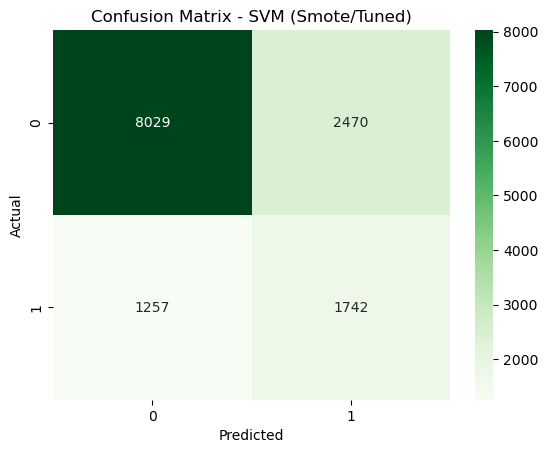

Accuracy Score:  0.7238850200029634
Precision Score:  0.41358024691358025
Recall Score:  0.5808602867622541
F1 Score:  0.48315074192206353
Specificity Score:  0.7647394989999048


In [ ]:
# Define string labels for display
target_names = ['0', '1'] 

# Generate predictions
svm_tuned_smote_pred = svm_best_model_smote.predict(X_smote_test)

# Classification report
print("\n SVM (Smote/Tuned):")
print(classification_report(y_test, svm_tuned_smote_pred, target_names=target_names))

# Confusion matrix
cm_svm_tuned_smote = confusion_matrix(y_test, svm_tuned_smote_pred, labels=[0, 1])
sns.heatmap(cm_svm_tuned_smote, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM (Smote/Tuned)')
plt.show()

# Model Scores
print('Accuracy Score: ', accuracy_score(y_test, svm_tuned_smote_pred))
print('Precision Score: ', precision_score(y_test, svm_tuned_smote_pred))
print('Recall Score: ', recall_score(y_test, svm_tuned_smote_pred))
print('F1 Score: ', f1_score(y_test, svm_tuned_smote_pred))

tn_bm_smote = cm_svm_tuned_smote [0,0]
fp_bm_smote = cm_svm_tuned_smote [0,1]
specificity_bm_smote = tn_bm_smote/(tn_bm_smote+fp_bm_smote)
print('Specificity Score: ', specificity_bm_smote)

<h2> Learning Curve </h2>

In [ ]:
# --- Learning Curve ---

print("\n--- Learning Curve ---")

def plot_learning_curve(estimator, title, X, y, axes=None, train_sizes=np.linspace(0.1, 1.0, 5), cv=None, scoring='accuracy'):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(10, 6))

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, train_sizes=train_sizes, cv=cv, scoring=scoring, n_jobs=-1
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axes.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes.set_title(title)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")
    axes.grid()
    axes.legend(loc="best")
    return plt

# Plot learning curves for different models
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
# Base
plot_learning_curve(SVC(kernel='rbf', C=10, random_state=42),
                    "SVM (Base)",  
                    X_train_scaled, y_train, axes=axes[0], cv=5)

# SMOTE
plot_learning_curve(SVC(kernel='rbf', C=10, random_state=42),
                    "SVM (SMOTE)", 
                    X_smote_train, y_smote_train, axes=axes[1], cv=5)
# SMOTE/Tuned
plot_learning_curve(svm_best_model,
                    "SVM (SMOTE/Tuned)", 
                    X_smote_train, y_smote_train, axes=axes[2], cv=5)

plt.tight_layout()
plt.show()




--- Learning Curve ---
